In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")  # Setting the seaborn style
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import accuracy_score


In [4]:
# Load the dataset
data = pd.read_csv('/content/dataset.csv')

In [5]:
# Convert labels to binary format
data['Label'] = data['Label'].map({'Propaganda': 1, 'Non-Propaganda': 0})
data = data.dropna()


In [6]:
data['Label'].value_counts()

1.0    44
0.0    34
Name: Label, dtype: int64

In [7]:
# Assuming 'target_label' is the column name of your target label
target_counts = data['Label'].value_counts()
total_counts = len(data)


(array([ 0., 10., 20., 30., 40., 50.]),
 [Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50')])

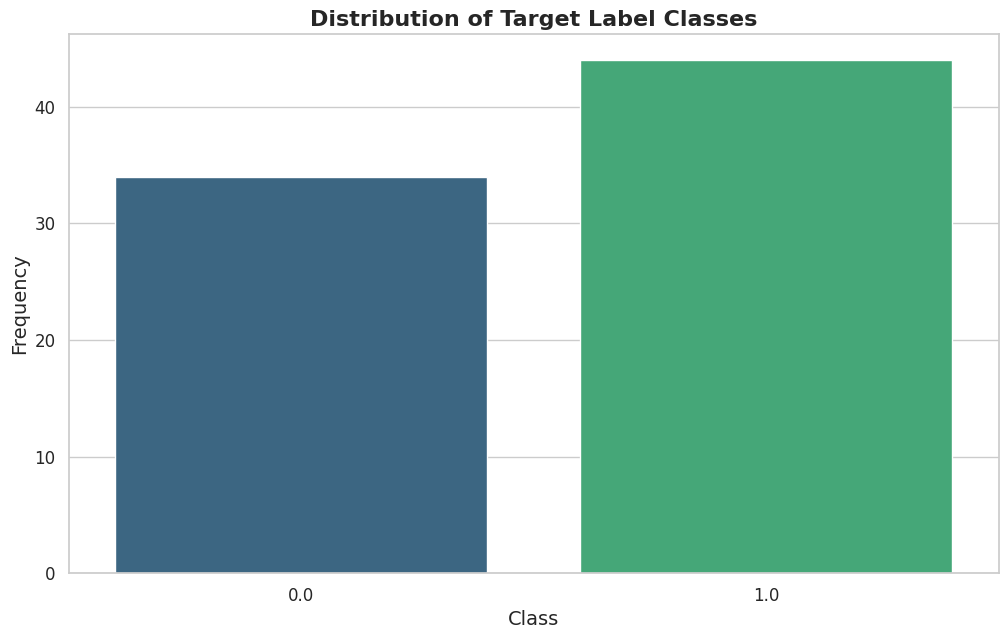

In [8]:
# Using Seaborn to create a stylized bar plot with percentages
plt.figure(figsize=(12, 7))
ax = sns.countplot(x='Label', data=data, palette='viridis')
plt.title('Distribution of Target Label Classes', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [9]:

# Adding percentage annotations on the bars
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_counts)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + 0.01 * total_counts  # Adjusting the height for annotation
    ax.annotate(percentage, (x, y), ha='center', fontsize=12)

# Removing the top and right spines for a cleaner look
sns.despine()

plt.show()

<Figure size 640x480 with 0 Axes>

In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Label'], test_size=0.2, random_state=42)


In [11]:
# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [12]:
# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.875
Precision: 0.8333333333333334
Recall: 1.0
F1 Score: 0.9090909090909091


In [16]:
# Load the dataset
dataset = pd.read_csv('/content/dataset.csv')  # Replace with your file path

In [17]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset['Label'])

In [18]:

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(dataset['Text'], encoded_labels, test_size=0.2, random_state=42)


In [19]:
# RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [20]:
# Tokenization function
def tokenize_batch(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=128, return_tensors="pt")



In [21]:
train_encodings = tokenize_batch(train_texts)
val_encodings = tokenize_batch(val_texts)

# Convert to torch dataset
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=RandomSampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=16, sampler=SequentialSampler(val_dataset))



In [22]:
# RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}: Average training loss: {avg_train_loss}")

# Evaluation
model.eval()
predictions, true_labels = [], []


Epoch 0: Average training loss: 1.0332349687814713
Epoch 1: Average training loss: 0.720614954829216
Epoch 2: Average training loss: 0.36371949315071106
Epoch 3: Average training loss: 0.2910748180001974


In [24]:
for batch in val_loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

accuracy = accuracy_score(true_labels, predictions)
print("Accuracy: ", accuracy)

Accuracy:  1.0
